In [ ]:
Does decoding enhance for the stimulus of interest?
    split high and low cue into high vs med score

Q. is the decoding accuracy better for expected vs unexpected trials?

Methods:
1. apply NPS ROI mask
2. extract patterns and classify based on expect/unexpect trials
3. calcualate accuracy and f1 scores
4. 




In [1]:
import os
import re
import json
import glob
from datetime import datetime
from os.path import join
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import joblib
import h5py


from nilearn import image, masking, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker


import neuromaps
from neuromaps import datasets as neuromaps_datasets
from neuromaps.datasets import fetch_annotation, fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
from neuromaps.transforms import fsaverage_to_fslr

from netneurotools import datasets as nntdata

from surfplot import Plot
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import seaborn as sns
import matplotlib.pyplot as plt


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## load nifti files

`scripts/step12_multiclass/mask_singletrial.py` <br>
`scripts/step12_multiclass/mask_singletrial.sh`

## check properties of mask

In [2]:
image.load_img('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/npspos_dACC.nii').get_fdata()

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [3]:
np.unique(image.load_img('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/npspos_dACC.nii').get_fdata())

array([0., 1.])

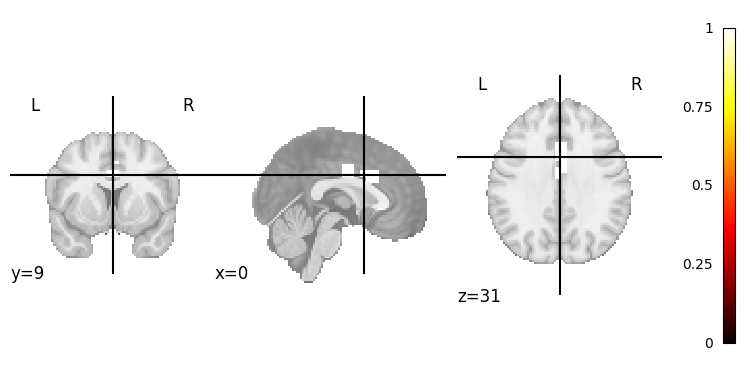

In [4]:
plotting.plot_stat_map(image.load_img('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/npspos_dACC.nii'))

In [37]:
from nilearn.input_data import NiftiMasker

# load mask, resample to mni 3mm and fit _______________________________________
mask_img_path = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/data/atlas/npsneg_rLOC.nii'
mni_template = datasets.load_mni152_template(resolution=3) # load MNI
resampled_mask_mni = image.resample_to_img(mask_img, mni_template, interpolation='nearest')
masker = NiftiMasker(mask_img=resampled_mask_mni)
masker.fit()

# For each NIfTI file, transform them into 2D arrays ___________________________
resampled_nifti_files = [image.resample_to_img(file, mni_template) for file in flattened_list]
masked_niftiarray = [masker.transform(file) for file in resampled_nifti_files]

In [96]:
npsneg_lLOC = np.vstack(masked_niftiarray)
singletrial_fname = [os.path.basename(fname) for fname in flattened_list]
npspos_dACCdf = pd.DataFrame({'singletrial_fname': singletrial_fname})

def extract_metadata(filename):
    pattern = re.compile(
        r"(?P<sub>sub-\d+)_"
        r"(?P<ses>ses-\d+)_"
        r"(?P<run>run-\d+)_"
        r"runtype-(?P<runtype>\w+)_"
        r"event-(?P<event>\w+)_"
        r"(?P<trial>trial-\d+)_"
        r"cuetype-(?P<cuetype>\w+)"
    )
    match = pattern.search(filename)
    if match:
        
        metadata = match.groupdict()
        metadata['cue'] = metadata['cuetype'] + '_cue'
        return metadata
    return {}
metadata_df = pd.DataFrame(npspos_dACCdf['singletrial_fname'].apply(extract_metadata).tolist())
metadata_df = pd.concat([metadata_df, npspos_dACCdf], axis=1)


prefix = "NPSneg_lLOC_"
columns = [prefix + str(i) for i in range(npsneg_lLOC.shape[1])]
arraydf = pd.DataFrame(npsneg_lLOC, columns=columns)

npspos_dACCdf = pd.concat([metadata_df, arraydf], axis=1)

# combined brain data with metadata


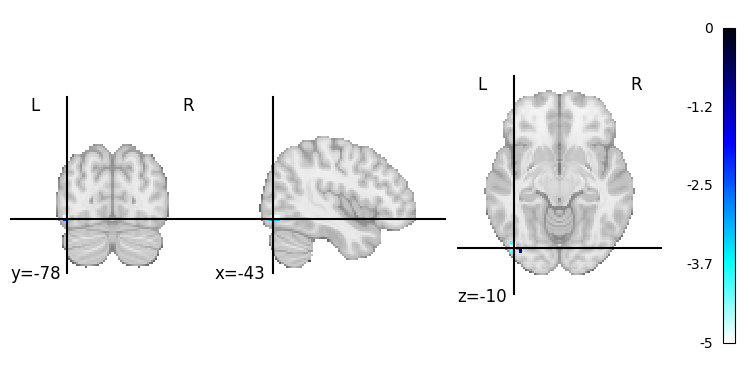

In [38]:
# Assuming 'masked_array' has been modified or analyzed and you want to project it back
nifti_from_array = masker.inverse_transform(masked_niftiarray[0])
plotting.plot_stat_map(nifti_from_array)

In [97]:
npspos_dACCdf.head()

,sub,ses,run,runtype,event,trial,cuetype,cue,singletrial_fname,NPSneg_lLOC_0,...,NPSneg_lLOC_9,NPSneg_lLOC_10,NPSneg_lLOC_11,NPSneg_lLOC_12,NPSneg_lLOC_13,NPSneg_lLOC_14,NPSneg_lLOC_15,NPSneg_lLOC_16,NPSneg_lLOC_17,NPSneg_lLOC_18
0,sub-0002,ses-03,run-01,vicarious,cue,trial-001,high,high_cue,sub-0002_ses-03_run-01_runtype-vicarious_event...,-4.266060,...,-4.956406,-3.330063,-4.777115,-2.502362,-2.842179,-3.265618,-1.353971,-1.239563,-1.921040,-1.329975
1,sub-0002,ses-03,run-03,cognitive,cue,trial-004,high,high_cue,sub-0002_ses-03_run-03_runtype-cognitive_event...,-0.288603,...,1.824891,1.293220,0.907481,1.451925,1.508815,1.595987,1.413662,0.679386,1.608770,1.301703
2,sub-0002,ses-03,run-02,pain,cue,trial-006,high,high_cue,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,-4.280744,...,-3.418663,-2.259036,-2.382655,-1.292055,-2.193433,-2.657365,0.056919,-1.566082,-1.380283,-2.391500
3,sub-0002,ses-03,run-01,vicarious,cue,trial-000,low,low_cue,sub-0002_ses-03_run-01_runtype-vicarious_event...,6.974098,...,5.448395,3.464488,4.105056,4.463082,4.417250,4.020146,3.313021,2.454030,3.556357,2.389647
4,sub-0002,ses-03,run-05,vicarious,cue,trial-011,low,low_cue,sub-0002_ses-03_run-05_runtype-vicarious_event...,0.198416,...,1.503461,0.549642,0.727053,0.136249,0.988291,1.353215,0.181702,0.254383,0.685257,0.529189


# load data

In [5]:
# once the voxels values are extracted
data_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv02_parcel-NPS'
npy_nps = np.load(join(data_dir, "npspos_dACC_event-stimulus.npy"))
npy_nps_metadata = join(data_dir, "npspos_dACC_event-stimulus.json")
with open(npy_nps_metadata, 'r') as file:
    npy_nps_meta = json.load(file)
# feed it through the SVM pipeline

In [10]:
# load numpy
# load json file with metadata

# combine as pandas
# npsneg_lLOC = np.vstack(masked_niftiarray)
npsneg_lLOC = npy_nps
singletrial_fname = npy_nps_meta['filenames']
npspos_dACCdf = pd.DataFrame({'singletrial_fname': singletrial_fname})

def extract_metadata(filename):
    pattern = re.compile(
        r"(?P<sub>sub-\d+)_"
        r"(?P<ses>ses-\d+)_"
        r"(?P<run>run-\d+)_"
        r"runtype-(?P<runtype>\w+)_"
        r"event-(?P<event>\w+)_"
        r"(?P<trial>trial-\d+)_"
        r"cuetype-(?P<cuetype>\w+)_"
        r"stimintensity-(?P<stimulusintensity>\w+)"
    )
    match = pattern.search(filename)
    if match:
        
        metadata = match.groupdict()
        metadata['cue'] = metadata['cuetype'] + '_cue'
        metadata['stim'] = metadata['stimulusintensity'] + '_stim'
        return metadata
    
    return {}
metadata_df = pd.DataFrame(npspos_dACCdf['singletrial_fname'].apply(extract_metadata).tolist())
metadata_df = pd.concat([metadata_df, npspos_dACCdf], axis=1)


prefix = "NPSpos_dACC_"
columns = [prefix + str(i) for i in range(npsneg_lLOC.shape[1])]
arraydf = pd.DataFrame(npsneg_lLOC, columns=columns)

npspos_dACCdf = pd.concat([metadata_df, arraydf], axis=1)

In [11]:
npspos_dACCdf

,sub,ses,run,runtype,event,trial,cuetype,stimulusintensity,cue,stim,...,NPSpos_dACC_172,NPSpos_dACC_173,NPSpos_dACC_174,NPSpos_dACC_175,NPSpos_dACC_176,NPSpos_dACC_177,NPSpos_dACC_178,NPSpos_dACC_179,NPSpos_dACC_180,NPSpos_dACC_181
0,sub-0002,ses-03,run-02,pain,stimulus,trial-009,high,high,high_cue,high_stim,...,1.388228,0.904351,-0.255798,-0.263679,-0.030048,0.071986,0.888774,0.464462,1.214903,0.777590
1,sub-0002,ses-04,run-05,cognitive,stimulus,trial-010,low,med,low_cue,med_stim,...,-0.238658,-0.336323,0.301502,-0.011044,0.134401,-0.113778,-0.072287,-0.104584,-0.412053,-0.478856
2,sub-0002,ses-04,run-02,cognitive,stimulus,trial-005,low,low,low_cue,low_stim,...,0.650335,0.942116,0.510449,0.730210,0.573041,0.723064,0.386306,0.541142,0.559737,0.767509
3,sub-0002,ses-04,run-05,cognitive,stimulus,trial-006,low,high,low_cue,high_stim,...,0.182327,0.333341,0.120561,-0.026085,0.106933,-0.019725,-0.143775,-0.050420,-0.166975,-0.173536
4,sub-0002,ses-03,run-03,cognitive,stimulus,trial-007,high,high,high_cue,high_stim,...,0.803049,0.759632,-0.189801,-0.150728,-0.156958,-0.084024,0.305832,0.234135,0.815478,0.763881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17106,sub-0133,ses-04,run-02,pain,stimulus,trial-008,high,high,high_cue,high_stim,...,0.471998,0.731039,0.210806,0.236812,0.192283,0.302114,0.194005,0.279914,0.516217,0.705958
17107,sub-0133,ses-04,run-03,vicarious,stimulus,trial-008,low,med,low_cue,med_stim,...,0.539269,0.826191,0.239379,-0.022515,0.204048,0.103741,0.544395,0.593226,0.824838,0.948978
17108,sub-0133,ses-03,run-04,cognitive,stimulus,trial-000,high,low,high_cue,low_stim,...,1.271826,2.075302,0.572015,0.459538,0.913633,0.773790,1.183248,1.478207,1.582399,2.033468
17109,sub-0133,ses-03,run-05,vicarious,stimulus,trial-001,high,med,high_cue,med_stim,...,0.427253,0.620623,0.243672,-0.080139,0.145775,0.039234,0.283725,0.347326,0.566183,0.712040


# balancer

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.utils import resample

# Given variables: X (data array), Y (factorized labels), groups (array of group labels)
high_cue_pain_index = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & (npspos_dACCdf['cue'] == 'high_cue') ].index
df_pain_highcue = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & (npspos_dACCdf['cue'] == 'high_cue') ].copy().reset_index(drop=True) #  & (npspos_dACCdf['ses'] == 'ses-01')
groups, unique_groups=pd.factorize(df_pain_highcue['sub'])
# Convert groups to an array if it's not already
groups_array = np.array(groups[0])

# Find unique groups
unique_groups = np.unique(groups_array)

# Initialize lists to hold the balanced dataset
X_balanced = []
Y_balanced = []
groups_balanced = []

for group in unique_groups:
    # print(group)
    # Indices for the current group
    group_indices = np.where(groups_array == group)[0]
    print(group)
    # Extract current group's data and labels
    X_group = X[group_indices]
    Y_group = Y[group_indices]
    
    # Get the smallest class size within this group
    min_class_size = min(np.bincount(Y_group).min(), group_indices.size)
    if min_class_size > 0:
        # Initialize temporary lists for the group's balanced data
        X_group_balanced = []
        Y_group_balanced = []
        
        # Balance each class within the group
        for class_label in np.unique(Y_group):
            # print(class_label)
            # Indices for the current class within the group
            class_indices = np.where(Y_group == class_label)[0]
            
            # Resample the class to the target size
            resampled_indices = resample(class_indices, n_samples=min_class_size, replace=False, random_state=42)
            
            # Append resampled data and labels to the group's temporary lists
            X_group_balanced.append(X_group[resampled_indices])
            Y_group_balanced.append(Y_group[resampled_indices])
        
        # Concatenate balanced data for the current group and append to the overall balanced lists
        X_balanced.append(np.vstack(X_group_balanced))
        Y_balanced.append(np.concatenate(Y_group_balanced))
        groups_balanced += [group] * min_class_size * len(np.unique(Y_group))
    else:
        print("f{group} does not have trials in one of the classes")

# Concatenate all balanced data from each group to form the final balanced dataset
X_balanced = np.vstack(X_balanced)
Y_balanced = np.concatenate(Y_balanced)
groups_balanced = np.array(groups_balanced)

# Now, X_balanced, Y_balanced, and groups_balanced contain your balanced dataset respecting the original group structure


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_33588/191248209.py:24: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  group_indices = np.where(groups_array == group)[0]


0


NameError: name 'X' is not defined

## svm high cue high stim medstim

sub-0005 number of trials: 16
sub-0013 number of trials: 16
sub-0014 number of trials: 16
sub-0015 number of trials: 8
sub-0016 number of trials: 18
sub-0017 number of trials: 8
sub-0018 number of trials: 16
sub-0019 number of trials: 12
sub-0021 number of trials: 16
sub-0025 number of trials: 24
sub-0026 number of trials: 16
sub-0028 number of trials: 8
sub-0029 number of trials: 24
sub-0030 number of trials: 8
sub-0031 number of trials: 24
sub-0032 number of trials: 21
sub-0033 number of trials: 24
sub-0035 number of trials: 16
sub-0036 number of trials: 24
sub-0037 number of trials: 24
sub-0038 number of trials: 23
sub-0039 number of trials: 16
sub-0040 number of trials: 16
sub-0041 number of trials: 6
sub-0043 number of trials: 23
sub-0044 number of trials: 23
sub-0047 number of trials: 8
sub-0050 number of trials: 15
sub-0051 number of trials: 24
sub-0052 number of trials: 19
sub-0053 number of trials: 24
sub-0055 number of trials: 24
sub-0056 number of trials: 24
sub-0057 number 

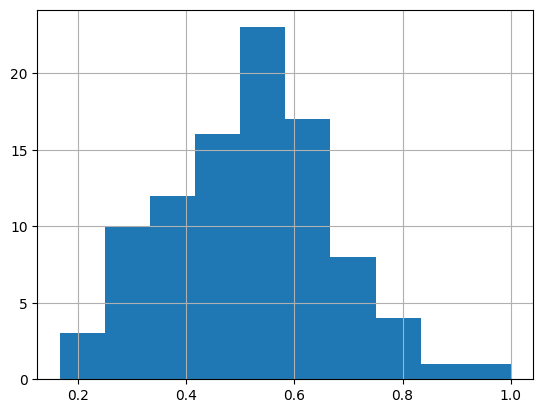

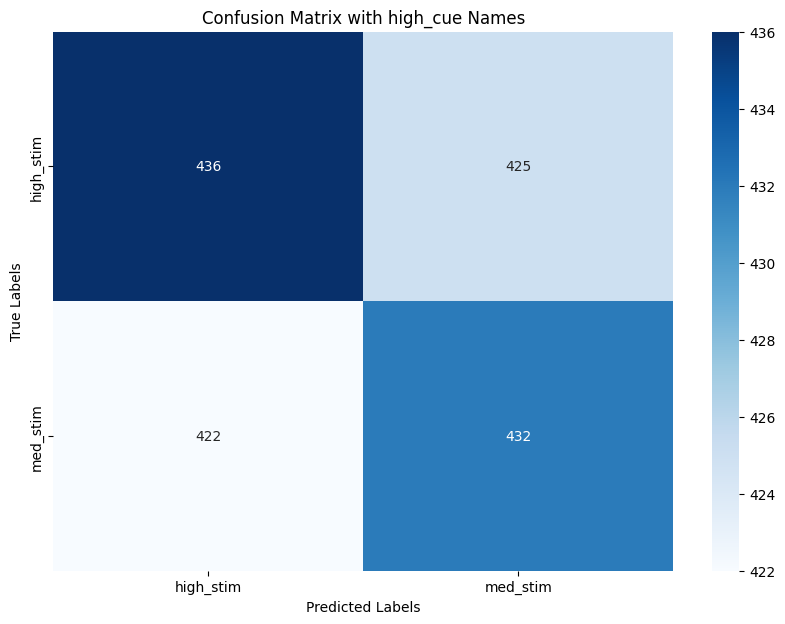

Normalized Confusion Matrix (by Actual Class Totals):
[[0.50638792 0.49361208]
 [0.4941452  0.5058548 ]]


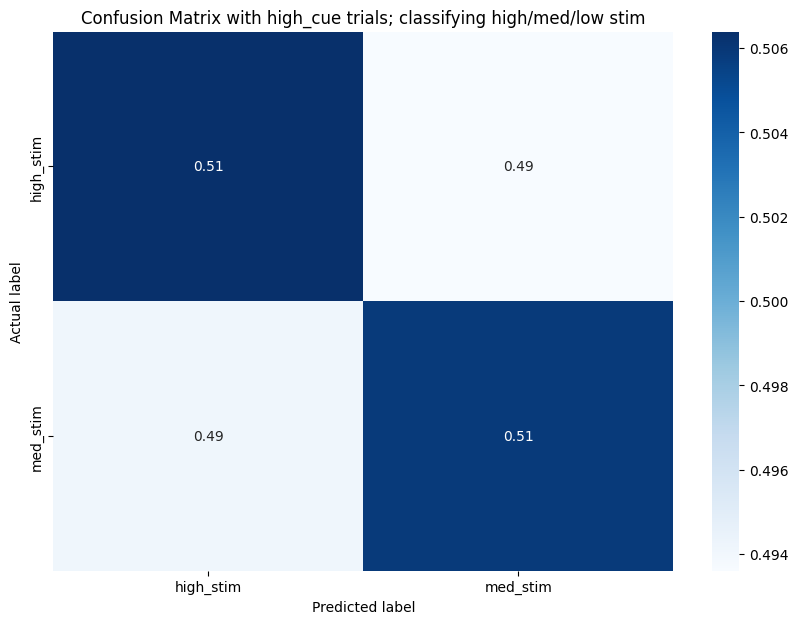

In [16]:
all_Y_test = []
all_Y_pred = []
overall_results = []
# Filter out participants with only one run
cuetype = 'high_cue'
# Loop over each subject
high_cue_pain_index = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                    (npspos_dACCdf['cue'] == cuetype) &
                                    ((npspos_dACCdf['stim'] == 'high_stim') | (npspos_dACCdf['stim'] == 'med_stim' )) ].index
df_pain_highcue = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                (npspos_dACCdf['cue'] == cuetype) &
                                ((npspos_dACCdf['stim'] == 'high_stim') | (npspos_dACCdf['stim'] == 'med_stim' ))
                                ].copy().reset_index(drop=True)
#(npspos_dACCdf['ses'] == 'ses-01')
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]

for sub in df_filtered['sub'].unique():
    # Subset data for the current subject
    df_sub = df_pain_highcue[df_pain_highcue['sub'] == sub]
    
    
    # Ensure corresponding brain data is selected
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
    print(f"{sub} number of trials: {len(Y)}")
    # Optionally, perform cross-validation within this subject's data
    accuracies = []
    groups = df_sub['run']
    cv = StratifiedKFold(n_splits=len(groups.unique()), shuffle=True, random_state=42)
    
    # cv = StratifiedKFold(n_splits=len(df_sub['run'].unique()), shuffle=True, random_state=42)
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
    # for train_idx, test_idx in cv.split(X, Y):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Initialize and train the SVM model
        svm = SVC(kernel='linear')
        svm.fit(X_train, Y_train)
        
        # Predict and evaluate
        Y_pred = svm.predict(X_test)
        accuracies.append(accuracy_score(Y_test, Y_pred))
        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(accuracies)
    overall_results.append({'sub': sub, 'accuracy': mean_accuracy})

# Convert overall results to a DataFrame for easier analysis and visualization
results_df = pd.DataFrame(overall_results)

# elapsed_time = time.perf_counter() - start_time
# print(f"Elapsed time: {elapsed_time} seconds")
print(results_df)
results_df.accuracy.hist()
results_df.accuracy.mean()
print(f"intercept: {svm.intercept_}\n classes: {uniques[svm.classes_]} {uniques}")


# _____________ confusion matrix ________________________________________________

f1 = f1_score(all_Y_test, all_Y_pred, average='weighted')  # Use 'binary', 'micro', 'macro', or 'weighted'
print(f"F1 Score: {f1}")

# original_class_names = np.array(uniques)
# # The desired order for the classes
desired_class_order = [ 'high_stim', 'med_stim' 
                       ]


# # Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix with {cuetype} Names')
plt.show()

from sklearn.metrics import confusion_matrix
import numpy as np

# Assume y_true and y_pred are your true labels and predictions, respectively
# y_true = [...]
# y_pred = [...]
y_true = Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
y_pred = Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row normalization

print("Normalized Confusion Matrix (by Actual Class Totals):")
print(cm_normalized)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()


# high cue low stim med stim

sub-0005 number of trials: 16
sub-0013 number of trials: 16
sub-0014 number of trials: 16
sub-0015 number of trials: 8
sub-0016 number of trials: 19
sub-0017 number of trials: 8
sub-0018 number of trials: 16
sub-0019 number of trials: 12
sub-0021 number of trials: 16
sub-0025 number of trials: 24
sub-0026 number of trials: 16
sub-0028 number of trials: 8
sub-0029 number of trials: 24
sub-0030 number of trials: 8
sub-0031 number of trials: 24
sub-0032 number of trials: 22
sub-0033 number of trials: 24
sub-0035 number of trials: 16
sub-0036 number of trials: 24
sub-0037 number of trials: 24
sub-0038 number of trials: 24
sub-0039 number of trials: 16
sub-0040 number of trials: 16
sub-0041 number of trials: 7
sub-0043 number of trials: 22
sub-0044 number of trials: 23
sub-0047 number of trials: 8
sub-0050 number of trials: 15
sub-0051 number of trials: 24
sub-0052 number of trials: 20
sub-0053 number of trials: 24
sub-0055 number of trials: 24
sub-0056 number of trials: 24
sub-0057 number 

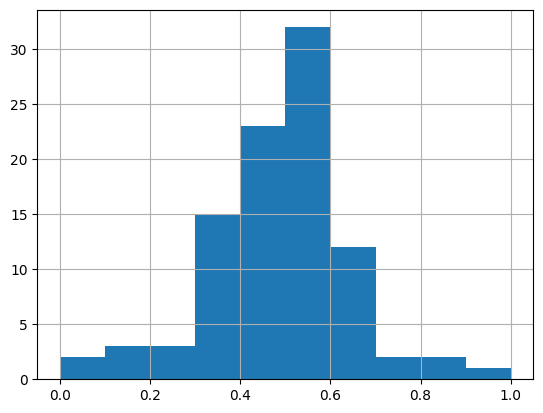

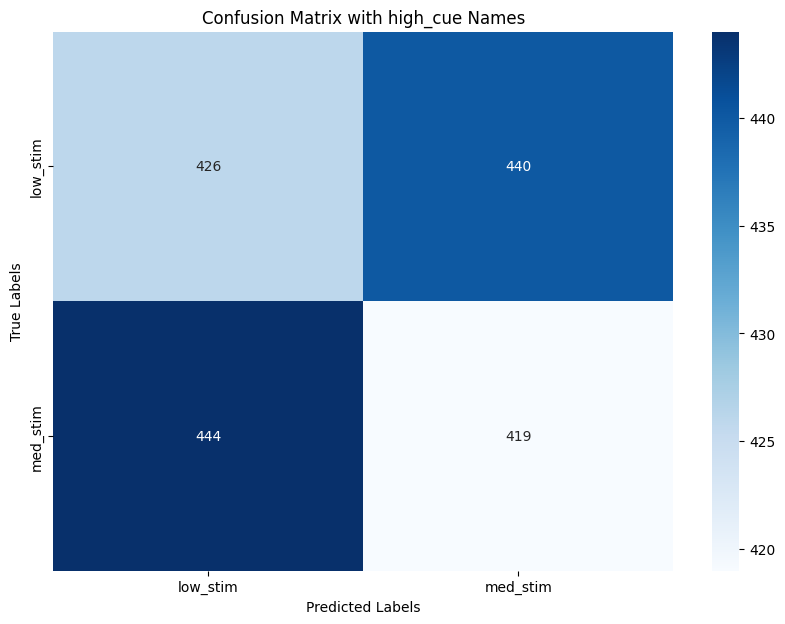

Normalized Confusion Matrix (by Actual Class Totals):
[[0.49191686 0.50808314]
 [0.51448436 0.48551564]]


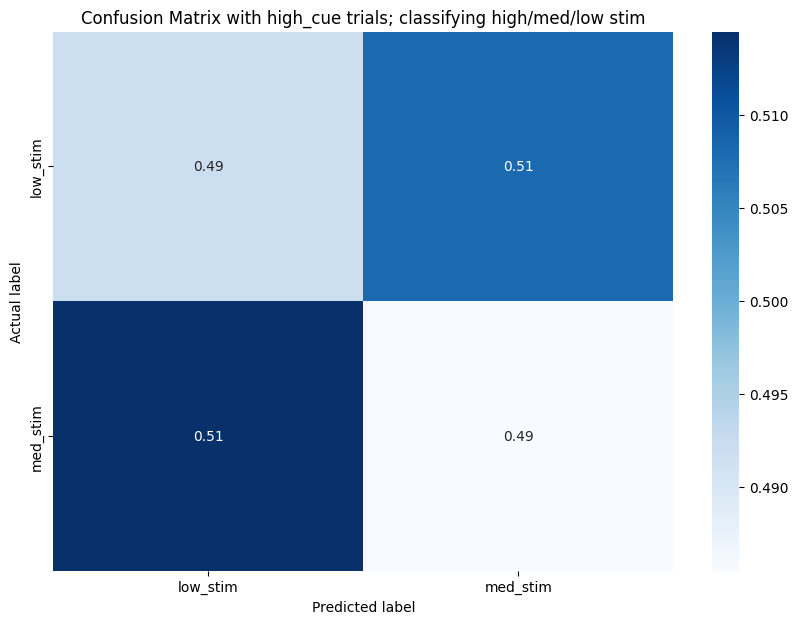

In [19]:
all_Y_test = []
all_Y_pred = []
overall_results = []
# Filter out participants with only one run
cuetype = 'high_cue'
# Loop over each subject
high_cue_pain_index = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                    (npspos_dACCdf['cue'] == cuetype) &
                                    ((npspos_dACCdf['stim'] == 'low_stim') | (npspos_dACCdf['stim'] == 'med_stim' )) ].index
df_pain_highcue = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                (npspos_dACCdf['cue'] == cuetype) &
                                ((npspos_dACCdf['stim'] == 'low_stim') | (npspos_dACCdf['stim'] == 'med_stim' ))
                                ].copy().reset_index(drop=True)
#(npspos_dACCdf['ses'] == 'ses-01')
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]

for sub in df_filtered['sub'].unique():
    # Subset data for the current subject
    df_sub = df_pain_highcue[df_pain_highcue['sub'] == sub]
    
    
    # Ensure corresponding brain data is selected
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
    print(f"{sub} number of trials: {len(Y)}")
    # Optionally, perform cross-validation within this subject's data
    accuracies = []
    groups = df_sub['run']
    cv = StratifiedKFold(n_splits=len(groups.unique()), shuffle=True, random_state=42)
    
    # cv = StratifiedKFold(n_splits=len(df_sub['run'].unique()), shuffle=True, random_state=42)
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
    # for train_idx, test_idx in cv.split(X, Y):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Initialize and train the SVM model
        svm = SVC(kernel='linear')
        svm.fit(X_train, Y_train)
        
        # Predict and evaluate
        Y_pred = svm.predict(X_test)
        accuracies.append(accuracy_score(Y_test, Y_pred))
        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(accuracies)
    overall_results.append({'sub': sub, 'accuracy': mean_accuracy})

# Convert overall results to a DataFrame for easier analysis and visualization
results_df = pd.DataFrame(overall_results)

# elapsed_time = time.perf_counter() - start_time
# print(f"Elapsed time: {elapsed_time} seconds")
print(results_df)
results_df.accuracy.hist()
results_df.accuracy.mean()
print(f"intercept: {svm.intercept_}\n classes: {uniques[svm.classes_]} {uniques}")


# _____________ confusion matrix ________________________________________________

f1 = f1_score(all_Y_test, all_Y_pred, average='weighted')  # Use 'binary', 'micro', 'macro', or 'weighted'
print(f"F1 Score: {f1}")

# original_class_names = np.array(uniques)
# # The desired order for the classes
desired_class_order = [ 'low_stim', 'med_stim' 
                       ]


# # Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix with {cuetype} Names')
plt.show()

from sklearn.metrics import confusion_matrix
import numpy as np

# Assume y_true and y_pred are your true labels and predictions, respectively
# y_true = [...]
# y_pred = [...]
y_true = Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
y_pred = Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row normalization

print("Normalized Confusion Matrix (by Actual Class Totals):")
print(cm_normalized)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()


# low cue high stim med stim

sub-0005 number of trials: 16
sub-0013 number of trials: 16
sub-0014 number of trials: 16
sub-0015 number of trials: 8
sub-0016 number of trials: 19
sub-0017 number of trials: 8
sub-0018 number of trials: 16
sub-0019 number of trials: 12
sub-0021 number of trials: 16
sub-0025 number of trials: 24
sub-0026 number of trials: 16
sub-0028 number of trials: 8
sub-0029 number of trials: 24
sub-0030 number of trials: 8
sub-0031 number of trials: 24
sub-0032 number of trials: 24
sub-0033 number of trials: 23
sub-0035 number of trials: 14
sub-0036 number of trials: 24
sub-0037 number of trials: 24
sub-0038 number of trials: 24
sub-0039 number of trials: 16
sub-0040 number of trials: 16
sub-0041 number of trials: 8
sub-0043 number of trials: 24
sub-0044 number of trials: 24
sub-0047 number of trials: 8
sub-0050 number of trials: 16
sub-0051 number of trials: 23
sub-0052 number of trials: 20
sub-0053 number of trials: 24
sub-0055 number of trials: 24
sub-0056 number of trials: 24
sub-0057 number 

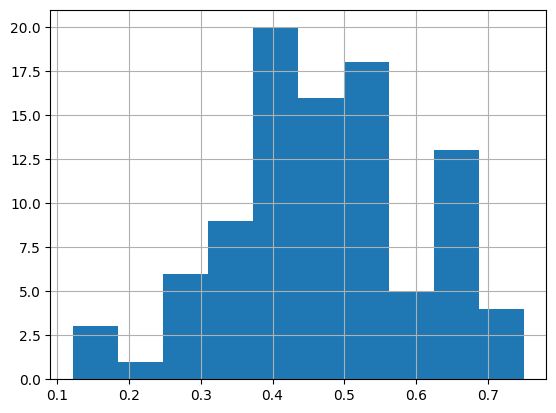

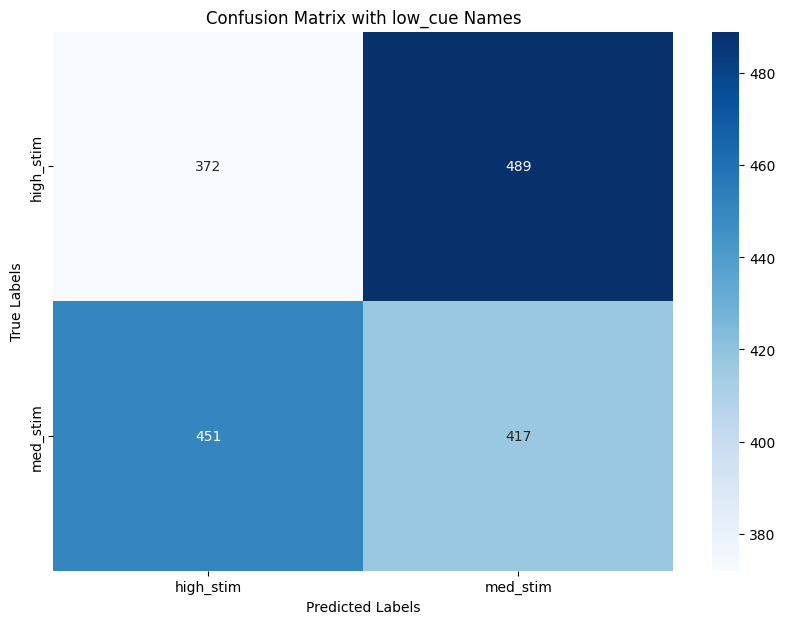

Normalized Confusion Matrix (by Actual Class Totals):
[[0.43205575 0.56794425]
 [0.51958525 0.48041475]]


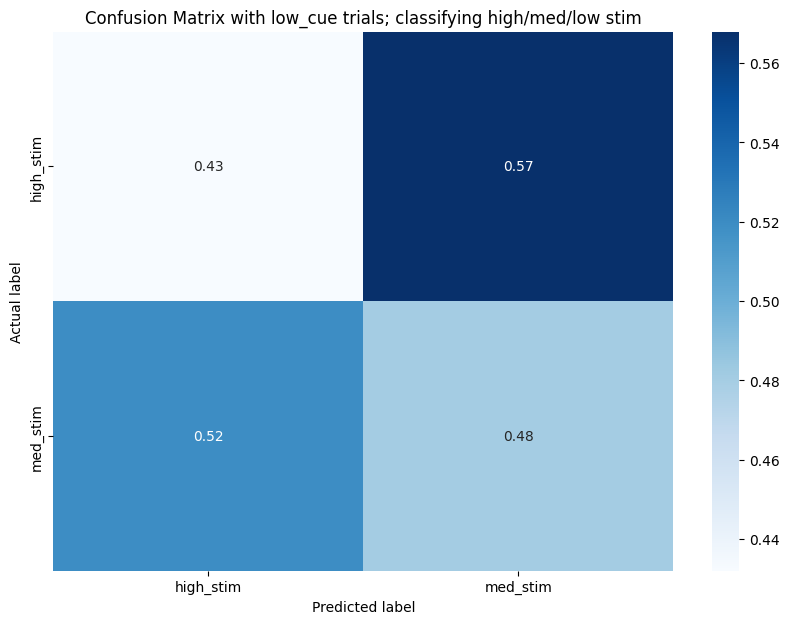

In [20]:
all_Y_test = []
all_Y_pred = []
overall_results = []
# Filter out participants with only one run
cuetype = 'low_cue'
# Loop over each subject
high_cue_pain_index = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                    (npspos_dACCdf['cue'] == cuetype) &
                                    ((npspos_dACCdf['stim'] == 'high_stim') | (npspos_dACCdf['stim'] == 'med_stim' )) ].index
df_pain_highcue = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                (npspos_dACCdf['cue'] == cuetype) &
                                ((npspos_dACCdf['stim'] == 'high_stim') | (npspos_dACCdf['stim'] == 'med_stim' ))
                                ].copy().reset_index(drop=True)
#(npspos_dACCdf['ses'] == 'ses-01')
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]

for sub in df_filtered['sub'].unique():
    # Subset data for the current subject
    df_sub = df_pain_highcue[df_pain_highcue['sub'] == sub]
    
    
    # Ensure corresponding brain data is selected
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
    print(f"{sub} number of trials: {len(Y)}")
    # Optionally, perform cross-validation within this subject's data
    accuracies = []
    groups = df_sub['run']
    cv = StratifiedKFold(n_splits=len(groups.unique()), shuffle=True, random_state=42)
    
    # cv = StratifiedKFold(n_splits=len(df_sub['run'].unique()), shuffle=True, random_state=42)
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
    # for train_idx, test_idx in cv.split(X, Y):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Initialize and train the SVM model
        svm = SVC(kernel='linear')
        svm.fit(X_train, Y_train)
        
        # Predict and evaluate
        Y_pred = svm.predict(X_test)
        accuracies.append(accuracy_score(Y_test, Y_pred))
        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(accuracies)
    overall_results.append({'sub': sub, 'accuracy': mean_accuracy})

# Convert overall results to a DataFrame for easier analysis and visualization
results_df = pd.DataFrame(overall_results)

# elapsed_time = time.perf_counter() - start_time
# print(f"Elapsed time: {elapsed_time} seconds")
print(results_df)
results_df.accuracy.hist()
results_df.accuracy.mean()
print(f"intercept: {svm.intercept_}\n classes: {uniques[svm.classes_]} {uniques}")


# _____________ confusion matrix ________________________________________________

f1 = f1_score(all_Y_test, all_Y_pred, average='weighted')  # Use 'binary', 'micro', 'macro', or 'weighted'
print(f"F1 Score: {f1}")

# original_class_names = np.array(uniques)
# # The desired order for the classes
desired_class_order = [ 'high_stim', 'med_stim' 
                       ]


# # Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix with {cuetype} Names')
plt.show()

from sklearn.metrics import confusion_matrix
import numpy as np

# Assume y_true and y_pred are your true labels and predictions, respectively
# y_true = [...]
# y_pred = [...]
y_true = Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
y_pred = Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row normalization

print("Normalized Confusion Matrix (by Actual Class Totals):")
print(cm_normalized)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()


# low cue low stim


sub-0005 number of trials: 16
sub-0013 number of trials: 16
sub-0014 number of trials: 16
sub-0015 number of trials: 8
sub-0016 number of trials: 17
sub-0017 number of trials: 8
sub-0018 number of trials: 16
sub-0019 number of trials: 12
sub-0021 number of trials: 16
sub-0025 number of trials: 23
sub-0026 number of trials: 16
sub-0028 number of trials: 8
sub-0029 number of trials: 24
sub-0030 number of trials: 8
sub-0031 number of trials: 24
sub-0032 number of trials: 22
sub-0033 number of trials: 24
sub-0035 number of trials: 15
sub-0036 number of trials: 24
sub-0037 number of trials: 24
sub-0038 number of trials: 24
sub-0039 number of trials: 16
sub-0040 number of trials: 15
sub-0041 number of trials: 8
sub-0043 number of trials: 24
sub-0044 number of trials: 24
sub-0047 number of trials: 8
sub-0050 number of trials: 16
sub-0051 number of trials: 24
sub-0052 number of trials: 20
sub-0053 number of trials: 24
sub-0055 number of trials: 23
sub-0056 number of trials: 24
sub-0057 number 

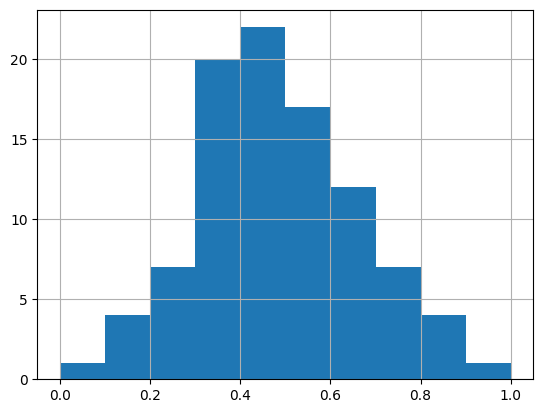

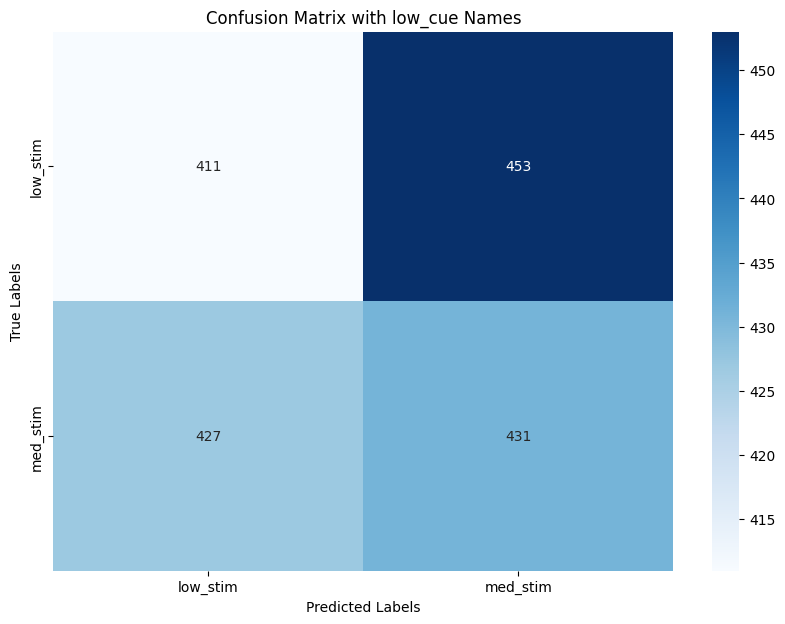

Normalized Confusion Matrix (by Actual Class Totals):
[[0.47569444 0.52430556]
 [0.497669   0.502331  ]]


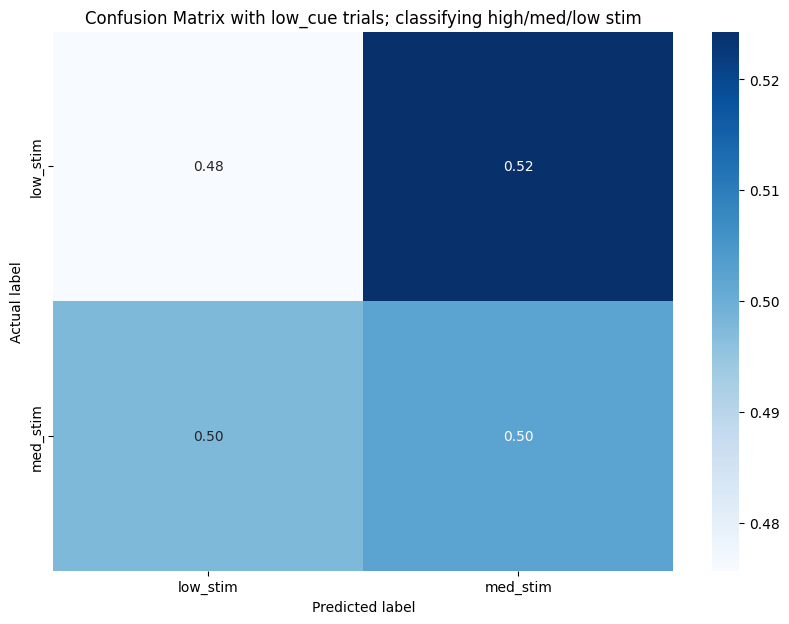

In [21]:
all_Y_test = []
all_Y_pred = []
overall_results = []
# Filter out participants with only one run
cuetype = 'low_cue'
# Loop over each subject
high_cue_pain_index = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                    (npspos_dACCdf['cue'] == cuetype) &
                                    ((npspos_dACCdf['stim'] == 'low_stim') | (npspos_dACCdf['stim'] == 'med_stim' )) ].index
df_pain_highcue = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                (npspos_dACCdf['cue'] == cuetype) &
                                ((npspos_dACCdf['stim'] == 'low_stim') | (npspos_dACCdf['stim'] == 'med_stim' ))
                                ].copy().reset_index(drop=True)
#(npspos_dACCdf['ses'] == 'ses-01')
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]

for sub in df_filtered['sub'].unique():
    # Subset data for the current subject
    df_sub = df_pain_highcue[df_pain_highcue['sub'] == sub]
    
    
    # Ensure corresponding brain data is selected
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
    print(f"{sub} number of trials: {len(Y)}")
    # Optionally, perform cross-validation within this subject's data
    accuracies = []
    groups = df_sub['run']
    cv = StratifiedKFold(n_splits=len(groups.unique()), shuffle=True, random_state=42)
    
    # cv = StratifiedKFold(n_splits=len(df_sub['run'].unique()), shuffle=True, random_state=42)
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
    # for train_idx, test_idx in cv.split(X, Y):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Initialize and train the SVM model
        svm = SVC(kernel='linear')
        svm.fit(X_train, Y_train)
        
        # Predict and evaluate
        Y_pred = svm.predict(X_test)
        accuracies.append(accuracy_score(Y_test, Y_pred))
        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(accuracies)
    overall_results.append({'sub': sub, 'accuracy': mean_accuracy})

# Convert overall results to a DataFrame for easier analysis and visualization
results_df = pd.DataFrame(overall_results)

# elapsed_time = time.perf_counter() - start_time
# print(f"Elapsed time: {elapsed_time} seconds")
print(results_df)
results_df.accuracy.hist()
results_df.accuracy.mean()
print(f"intercept: {svm.intercept_}\n classes: {uniques[svm.classes_]} {uniques}")


# _____________ confusion matrix ________________________________________________

f1 = f1_score(all_Y_test, all_Y_pred, average='weighted')  # Use 'binary', 'micro', 'macro', or 'weighted'
print(f"F1 Score: {f1}")

# original_class_names = np.array(uniques)
# # The desired order for the classes
desired_class_order = [ 'low_stim', 'med_stim' 
                       ]


# # Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix with {cuetype} Names')
plt.show()

from sklearn.metrics import confusion_matrix
import numpy as np

# Assume y_true and y_pred are your true labels and predictions, respectively
# y_true = [...]
# y_pred = [...]
y_true = Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
y_pred = Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row normalization

print("Normalized Confusion Matrix (by Actual Class Totals):")
print(cm_normalized)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()
